# Valid Python Notebook Analyses (RQ3, RQ4)

This notebooks analyzes the selection of Python notebooks with valid syntax in all cells. These analyses answer RQ3 and RQ4.

In [1]:
import sys
sys.path.insert(0, '../archaeology')

import re

from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib

from matplotlib import pyplot as plt

import analysis_helpers, importlib
importlib.reload(analysis_helpers)

from analysis_helpers import relative_var, cell_distribution
from analysis_helpers import savefig, display_counts, getitem
from analysis_helpers import dbmt, DBMT, print_relative_var_group
from analysis_helpers import load_vars, group_run, dbmt_relative_var
from analysis_helpers import dbmt_prepare_selectors
from db import connect

from astutils import chain_hist

%matplotlib inline

## Query

Select asts and modules from:

- existing

  ```n.skip & 2048 = 0```

- valid
  
  ```NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
  AND n.processed & 15 = 0 AND n.skip & (1024 + 512) = 0```


- non-duplicated
  
  ```n.skip & (1024 + 512 + 128) = 0```
  
- Python notebooks

  ```n.language = 'python' AND LEFT(n.language_version, 1) IN ('2', '3')```
  
- with valid syntax

  ```n.processed & 16 = 0```
  

In [2]:
%%time
with connect() as session:
    print("Query ASTs")
    asts = pd.read_sql("""
        SELECT a.*, n.stargazers, n.forks, n.starforks
        FROM notebooks n, notebook_asts a
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.language = 'python'
        AND n.processed & 16 = 0
        AND LEFT(n.language_version, 1) IN ('2', '3')
        AND a.notebook_id = n.id
    """, session.connection())
    

Query ASTs
CPU times: user 41 s, sys: 13.9 s, total: 54.9 s
Wall time: 59.6 s


In [3]:
%%time
with connect() as session:
    print("Query Notebooks")
    modules = pd.read_sql("""
        SELECT m.*, a.has_tests, a.has_unittests, n.stargazers, n.forks, n.starforks
        FROM notebooks n, notebook_modules m, notebooks_bool_aggregates a
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.language = 'python'
        AND n.processed & 16 = 0
        AND LEFT(n.language_version, 1) IN ('2', '3')
        AND m.notebook_id = n.id
        AND a.notebook_id = n.id
    """, session.connection())

Query Notebooks
CPU times: user 9.74 s, sys: 470 ms, total: 10.2 s
Wall time: 40.2 s


In [4]:
%%time
BINS = 1261
cell_type_bins_arrays = {
    key: {
        'has_import': np.zeros(BINS),
        'does_not_have_import': np.zeros(BINS),
    } for key, _ in DBMT + [(None, '<deleted>')]
}

with connect() as session:
    print("Query Bins")
    bin_arrays = session.execute("""
        SELECT m.notebook_id, m.bins_has_import, m.bins_does_not_have_import, n.stargazers, n.forks, n.starforks
        FROM notebooks n, notebooks_meta_aggregates m
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.language = 'python'
        AND n.processed & 16 = 0
        AND LEFT(n.language_version, 1) IN ('2', '3')
        AND m.notebook_id = n.id
    """)
    get_selectors = dbmt_prepare_selectors()
    for row in bin_arrays:
        selectors = get_selectors(row)
        if len(row.bins_has_import) > 1:
            for selector in selectors:
                cell_type_bins_arrays[selector]['has_import'] += np.array(row.bins_has_import)
        if len(row.bins_does_not_have_import) > 1:
            for selector in selectors:
                cell_type_bins_arrays[selector]['does_not_have_import'] += np.array(row.bins_does_not_have_import)
    print("Valid Python notebooks:", len(modules))


Query Bins
Valid Python notebooks: 886668
CPU times: user 3min 15s, sys: 2.26 s, total: 3min 17s
Wall time: 11min 42s


In [5]:
total_notebooks = len(modules)

## Modules

In [6]:
columns = [
    "any_any", "local_any", "external_any",
    "any_import_from", "local_import_from", "external_import_from",
    "any_import", "local_import", "external_import",
    "any_load_ext", "local_load_ext", "external_load_ext",
]
count_columns = [c + "_count" for c in columns]
for column in columns:
    modules[column] = modules[column].apply(lambda c: {a for a in c.split(",") if a})
    modules["toplevel_" + column] = modules[column].apply(lambda imports: {
        getitem(x.split("."), 0, x) for x in imports
    })
    modules["toplevel_" + column + "_count"] = modules["toplevel_" + column].apply(len)

modules.head(5)

,id,repository_id,notebook_id,index,index_count,any_any,any_any_count,local_any,local_any_count,external_any,...,toplevel_local_import,toplevel_local_import_count,toplevel_external_import,toplevel_external_import_count,toplevel_any_load_ext,toplevel_any_load_ext_count,toplevel_local_load_ext,toplevel_local_load_ext_count,toplevel_external_load_ext,toplevel_external_load_ext_count
0,445493,53320,383583,1,1,"{numpy, pandas, matplotlib.pyplot}",3,{},0,"{numpy, pandas, matplotlib.pyplot}",...,{},0,"{numpy, matplotlib, pandas}",3,{},0,{},0,{},0
1,118930,36449,284179,"1,5,7,8,43",5,"{weakref, sys, os}",3,{},0,"{weakref, sys, os}",...,{},0,"{weakref, sys, os}",3,{},0,{},0,{},0
2,526212,177716,1031182,,0,{},0,{},0,{},...,{},0,{},0,{},0,{},0,{},0
3,1020920,127862,796666,1,1,{collections},1,{},0,{collections},...,{},0,{},0,{},0,{},0,{},0
4,962139,65891,460855,"0,4",2,"{numpy, scipy}",2,{},0,"{numpy, scipy}",...,{},0,{numpy},1,{},0,{},0,{},0


### Notebooks with modules

In [7]:
dbmt_relative_var(
    "Notebooks with modules: {}", "a3_notebooks_with_modules",
    dbmt(modules[modules["any_any_count"] > 0]), 
    dbmt(modules),
)

Notebooks with modules: a3_notebooks_with_modules


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"810,659 (91.43%)",None,None,None,None,None
1,(Sample),sd_,61 (93.85%),0.01%,0.01%,102.65%,(+) 2.65%,2.42%
2,(Popular),td_,"25,383 (90.19%)",3.13%,2.86%,98.64%,(-) 1.36%,-1.24%


In [8]:
local_notebook = modules[modules["local_any_count"] > 0]
dbmt_relative_var(
    "Notebooks with local modules: {}",
    "a3_notebooks_with_local_modules",
    dbmt(local_notebook), 
    dbmt(modules)
)

Notebooks with local modules: a3_notebooks_with_local_modules


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"92,307 (10.41%)",None,None,None,None,None
1,(Sample),sd_,4 (6.15%),0.00%,0.00%,59.11%,(-) 40.89%,-4.26%
2,(Popular),td_,"3,076 (10.93%)",3.33%,0.35%,104.98%,(+) 4.98%,0.52%


### Which modules

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


,0
numpy,587.852
matplotlib,470.507
pandas,386.619
sklearn,224.524
os,149.693
scipy,140.785
seaborn,119.275
time,81.685
math,79.820
IPython,76.478


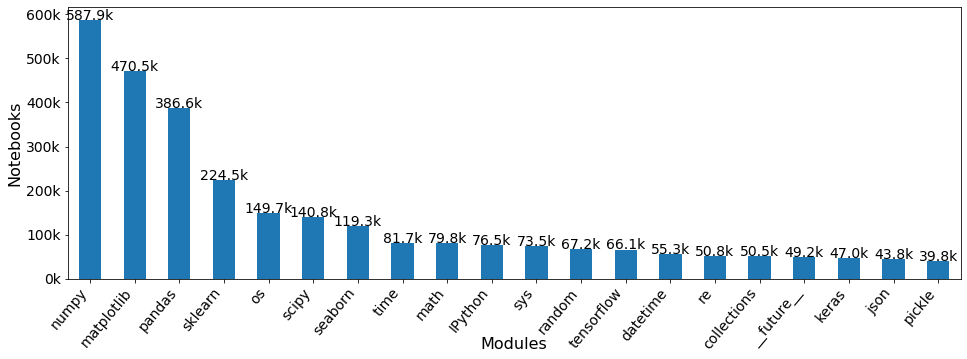

(Sample) 


,0
numpy,0.037
matplotlib,0.034
pandas,0.030
sklearn,0.016
os,0.016
time,0.009
seaborn,0.009
IPython,0.008
scipy,0.008
collections,0.005


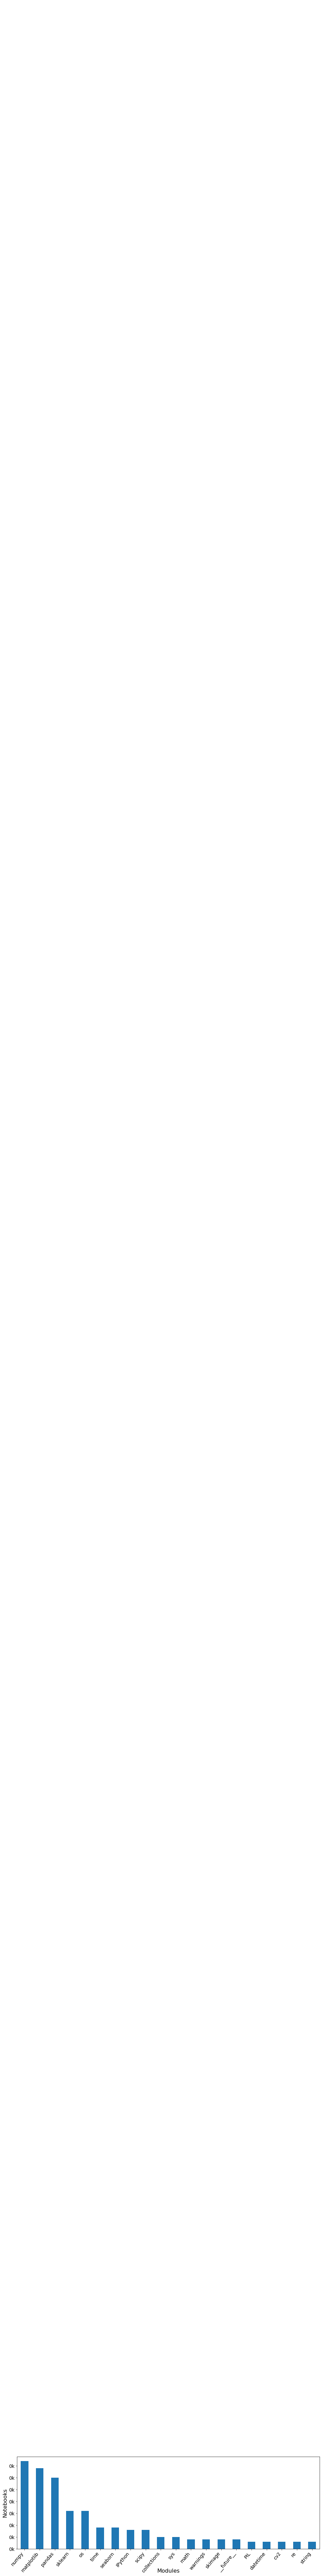

(Popular) 


,0
numpy,16.957
matplotlib,13.202
pandas,8.461
sklearn,5.552
os,4.315
scipy,3.796
math,3.410
IPython,2.892
seaborn,2.816
__future__,2.535


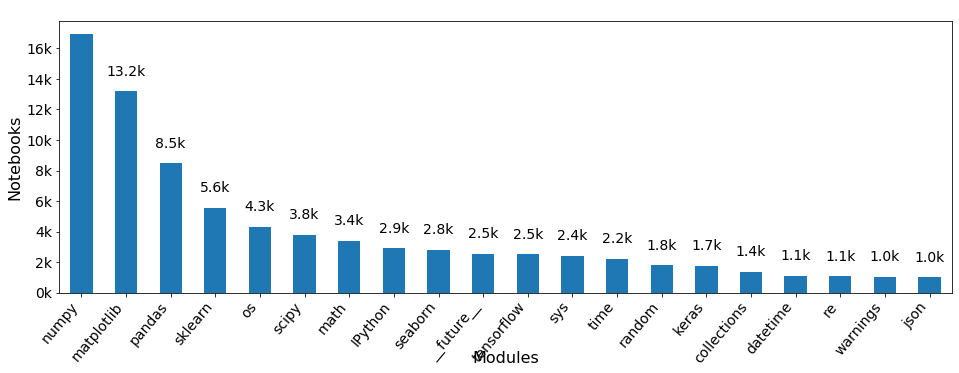

In [9]:
def notebook_module_toplevel(modules, prefix):
    counter = Counter()
    modules["toplevel_any_any"].agg(lambda x: counter.update(x))
    del counter['']
    counts = pd.Series(counter).sort_values(ascending=False)
    with savefig(prefix + "a3_notebook_module_toplevel", 16, 5):
        _, cnt = display_counts(
            counts / 1000.0, width=50, show_values=True, plot=False,
            cut=slice(None, 20), logy=False, template="{0:.1f}k", template2="{0:.0f}k",
            dtype=float
        )
        display(cnt)
        ax = plt.gca()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
        ax.legend().set_visible(False)
        ax.set_ylabel("Notebooks")
        ax.set_xlabel("Modules")
        ax.xaxis.labelpad = -15
        #ax.yaxis.labelpad = -15
        
group_run(dbmt(modules), DBMT, notebook_module_toplevel);

##  Import Distribution

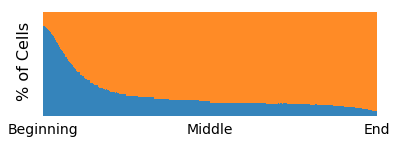

(Sample) 


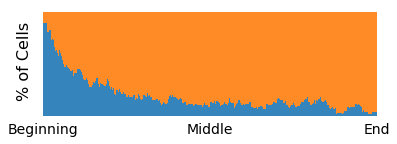

(Popular) 


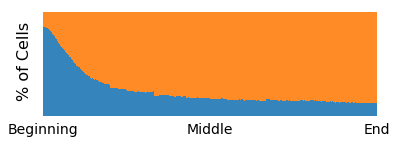

[None, None, None]

In [10]:
select = ["has_import", "does_not_have_import"]

def import_distribution(arrays, prefix):
    with cell_distribution(prefix + "a3_import_distribution", 6, 2, select, BINS - 1, arrays) as ax:
        pass
        #ax.annotate("no-import", xy=(930, 80), color="white", weight="bold")
        #ax.annotate("import", xy=(30, 5), color="white", weight="bold")
        
group_run([cell_type_bins_arrays[prefix] for prefix, _ in DBMT], DBMT, import_distribution)


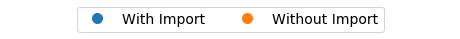

In [11]:


with savefig("a3_import_distribution_legend", 8, 0.3):
    texts = ["With Import", "Without Import"]
    colors = ["tab:blue", "tab:orange"]
    patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
                label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    plt.legend(handles=patches, bbox_to_anchor=(0.5, 0.5), 
               loc='center', ncol=3, numpoints=1 )
    ax = plt.gca()
    ax.axis("off")


## Tests

In [12]:
dbmt_relative_var(
    "Notebooks with tests: {}", "a3_notebooks_with_test",
    dbmt(modules[modules["has_tests"]]),
    dbmt(modules),
)

Notebooks with tests: a3_notebooks_with_test


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"13,894 (1.57%)",None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-1.57%
2,(Popular),td_,455 (1.62%),3.27%,0.05%,103.17%,(+) 3.17%,0.05%


In [13]:
dbmt_relative_var(
    "Notebooks with unittests: {}", "a3_notebooks_with_unittest",
    dbmt(modules[modules["has_unittests"]]), 
    dbmt(modules),
)

Notebooks with unittests: a3_notebooks_with_unittest


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"2,620 (0.30%)",None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.30%
2,(Popular),td_,21 (0.07%),0.80%,0.00%,25.25%,(-) 74.75%,-0.22%


## AST

### Variable

In [14]:
variable_histogram = group_run(dbmt(asts), DBMT, plot=False, fn=lambda asts, prefix: [
    ("Variable", "Main", len(asts[
        (asts["ast_assign"] != 0)
        | (asts["ast_augassign"] != 0)
        | (asts["ast_annassign"] != 0)
        | (asts["ast_delete"] != 0)
    ])),
    ("Assign", ">Variable", len(asts[
        (asts["ast_assign"] != 0)
    ])),
    ("AugAssign", ">Variable", len(asts[
        (asts["ast_augassign"] != 0)
    ])),
    #("AnnAssign", ">Variable", len(asts[
    #    (asts["ast_annassign"] != 0)
    #])),
    ("Delete", ">Variable", len(asts[
        (asts["ast_delete"] != 0)
        | (asts["delitem"] != 0)
    ])),
])
pprint(variable_histogram[0])

[('Variable', 'Main', 838858),
 ('Assign', '>Variable', 838819),
 ('AugAssign', '>Variable', 224613),
 ('Delete', '>Variable', 38872)]


### Definition

In [15]:
definitions_histogram = group_run(dbmt(asts), DBMT, plot=False, fn=lambda asts, prefix: [
    ("Definition", "Main", len(asts[
        (asts["ast_functiondef"] != 0)
        | (asts["ast_asyncfunctiondef"] != 0)
        | (asts["ast_classdef"] != 0)
        | (asts["ast_lambda"] != 0)
    ])),
    ("FunctionDef", ">Definition", len(asts[
        (asts["ast_functiondef"] != 0)
    ])),
    ("Lambda", ">Definition", len(asts[
        (asts["ast_lambda"] != 0)
    ])),
    ("ClassDef", ">Definition", len(asts[
        (asts["ast_classdef"] != 0)
    ])),
    ("Generator", ">Definition", len(asts[
        (asts["ast_yield"] != 0)
        | (asts["ast_yieldfrom"] != 0)
    ])),

    ("Decorator", ">Definition", len(asts[
        (asts["functions_with_decorators"] != 0)
        | (asts["classes_with_decorators"] != 0)
    ])),

])
pprint(definitions_histogram[0])

[('Definition', 'Main', 517768),
 ('FunctionDef', '>Definition', 481285),
 ('Lambda', '>Definition', 156171),
 ('ClassDef', '>Definition', 75809),
 ('Generator', '>Definition', 17778),
 ('Decorator', '>Definition', 12675)]


### Import

In [16]:
import_histogram = group_run(dbmt(asts), DBMT, plot=False, fn=lambda asts, prefix: [
    ("Module Import", "Main", len(asts[
        (asts["ast_import"] != 0)
        | (asts["ast_importfrom"] != 0)
    ])),
    ("Import", ">IModule mport", len(asts[
        (asts["ast_import"] != 0)
    ])),
    ("ImportFrom", ">Module Import", len(asts[
        (asts["ast_importfrom"] != 0)   
    ])),
])
pprint(import_histogram[0])

[('Module Import', 'Main', 808896),
 ('Import', '>IModule mport', 774115),
 ('ImportFrom', '>Module Import', 607284)]


### Data Structure

In [17]:
data_structure_histogram = group_run(dbmt(asts), DBMT, plot=False, fn=lambda asts, prefix: [
    ("Data Structure", "Main", len(asts[
        (asts["ast_list"] != 0)
        | (asts["ast_dict"] != 0)
        | (asts["ast_set"] != 0)
        | (asts["ast_tuple"] != 0)
    ])),
    ("List", ">Data Structure", len(asts[
        (asts["ast_list"] != 0)
    ])),
    ("Tuple", ">Data Structure", len(asts[
        (asts["ast_tuple"] != 0)
    ])),
    ("Dict", ">Data Structure", len(asts[
        (asts["ast_dict"] != 0)
    ])),
    ("Set", ">Data Structure", len(asts[
        (asts["ast_set"] != 0)
    ])),
])
pprint(data_structure_histogram[0])

[('Data Structure', 'Main', 768527),
 ('List', '>Data Structure', 686013),
 ('Tuple', '>Data Structure', 631587),
 ('Dict', '>Data Structure', 339882),
 ('Set', '>Data Structure', 7634)]


### Comprehension

In [18]:
comprehension_histogram = group_run(dbmt(asts), DBMT, plot=False, fn=lambda asts, prefix: [
    ("Comprehension", "Main", len(asts[
        (asts["ast_listcomp"] != 0)
        | (asts["ast_setcomp"] != 0)
        | (asts["ast_dictcomp"] != 0)
        | (asts["ast_generatorexp"] != 0)
    ])),

    ("ListComp", ">Comprehension", len(asts[
        (asts["ast_listcomp"] != 0)
    ])),
    ("GenExpr", ">Comprehension", len(asts[
        (asts["ast_generatorexp"] != 0)
    ])),
    ("DictComp", ">Comprehension", len(asts[
        (asts["ast_dictcomp"] != 0)
    ])),
    ("SetComp", ">Comprehension", len(asts[
        (asts["ast_setcomp"] != 0)
    ])),
])
pprint(comprehension_histogram[0])

[('Comprehension', 'Main', 272170),
 ('ListComp', '>Comprehension', 254373),
 ('GenExpr', '>Comprehension', 35753),
 ('DictComp', '>Comprehension', 30465),
 ('SetComp', '>Comprehension', 2275)]


### Loop

In [19]:
loop_histogram = group_run(dbmt(asts), DBMT, plot=False, fn=lambda asts, prefix: [
    ("Loop", "Main", len(asts[
        (asts["ast_for"] != 0)
        | (asts["ast_asyncfor"] != 0)
        | (asts["ast_while"] != 0)
        | (asts["ast_break"] != 0)
        | (asts["ast_continue"] != 0)
    ])),
    ("For", ">Loop", len(asts[
        (asts["ast_for"] != 0)
        | (asts["ast_asyncfor"] != 0)
    ])),
    ("While", ">Loop", len(asts[
        (asts["ast_while"] != 0)
    ])),
    ("Break", ">Loop", len(asts[
        (asts["ast_break"] != 0)
    ])),
    ("Continue", ">Loop", len(asts[
        (asts["ast_continue"] != 0)
    ])),
])
pprint(loop_histogram[0])

[('Loop', 'Main', 564435),
 ('For', '>Loop', 553038),
 ('While', '>Loop', 73837),
 ('Break', '>Loop', 51944),
 ('Continue', '>Loop', 37512)]


### Condition

In [20]:
condition_histogram = group_run(dbmt(asts), DBMT, plot=False, fn=lambda asts, prefix: [
    ("Condition", "Main", len(asts[
        (asts["ast_ifexp"] != 0)
        | (asts["ast_if"] != 0)
    ])),
    ("If", ">Condition", len(asts[
        (asts["ast_if"] != 0)
    ])),
    ("IfExp", ">Condition", len(asts[
        (asts["ast_ifexp"] != 0)
    ])),
])
pprint(condition_histogram[0])

[('Condition', 'Main', 423951),
 ('If', '>Condition', 408947),
 ('IfExp', '>Condition', 64076)]


### Exception

In [21]:
exception_histogram = group_run(dbmt(asts), DBMT, plot=False, fn=lambda asts, prefix: [
    ("Exception", "Main", len(asts[
        (asts["ast_assert"] != 0)
        | (asts["ast_raise"] != 0)
        | (asts["ast_tryexcept"] != 0)
        | (asts["ast_tryfinally"] != 0)
        | (asts["ast_try"] != 0)
        | (asts["ast_with"] != 0)
        | (asts["ast_asyncwith"] != 0)
    ])),
    ("With", ">Exception", len(asts[
        (asts["ast_with"] != 0)
        | (asts["ast_asyncwith"] != 0)
    ])),
    ("Try", ">Exception", len(asts[
        (asts["ast_tryexcept"] != 0)
        | (asts["ast_tryfinally"] != 0)
        | (asts["ast_try"] != 0)
    ])),
    ("Assert", ">Exception", len(asts[
        (asts["ast_assert"] != 0)
    ])),
    ("Raise", ">Exception", len(asts[
        (asts["ast_raise"] != 0)
    ])),

])
pprint(exception_histogram[0])

[('Exception', 'Main', 210298),
 ('With', '>Exception', 134737),
 ('Try', '>Exception', 67124),
 ('Assert', '>Exception', 38556),
 ('Raise', '>Exception', 24984)]


### Other

In [22]:
pass_histogram = group_run(dbmt(asts), DBMT, plot=False, fn=lambda asts, prefix: [
    ("Pass", "Main", len(asts[
        (asts["ast_pass"] != 0)
    ])),
])
ipython_histogram = group_run(dbmt(asts), DBMT, plot=False, fn=lambda asts, prefix: [
    ("IPython", "Main", len(asts[
        (asts["ipython_superset"] != 0)
        #| (asts["ipython"] != 0)
    ]))
])
other_histogram = group_run(
    zip(pass_histogram, ipython_histogram), DBMT, plot=False,
    fn=lambda x, prefix: x[0] + x[1]
)
pprint(other_histogram[0])

[('Pass', 'Main', 35990), ('IPython', 'Main', 458746)]


### Full

In [23]:
full_histogram = group_run(zip(
    variable_histogram,
    import_histogram,
    data_structure_histogram,
    loop_histogram,
    definitions_histogram,
    #ipython_histogram,
    condition_histogram,
    comprehension_histogram,
    exception_histogram,
), DBMT, plot=False, fn=lambda x, prefix: list(chain_hist(*x)))

### Plot

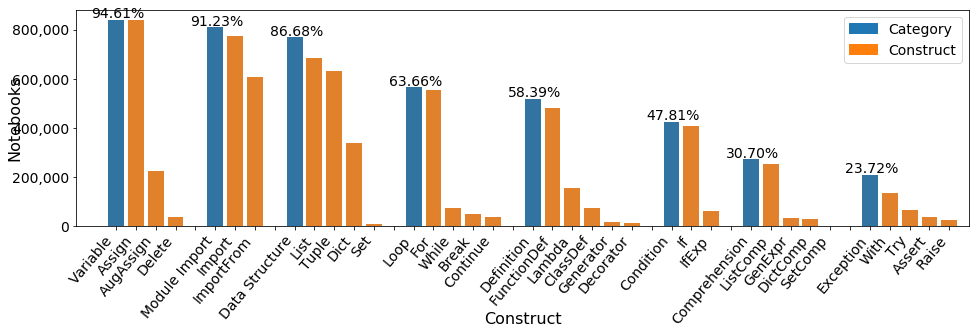

(Sample) 


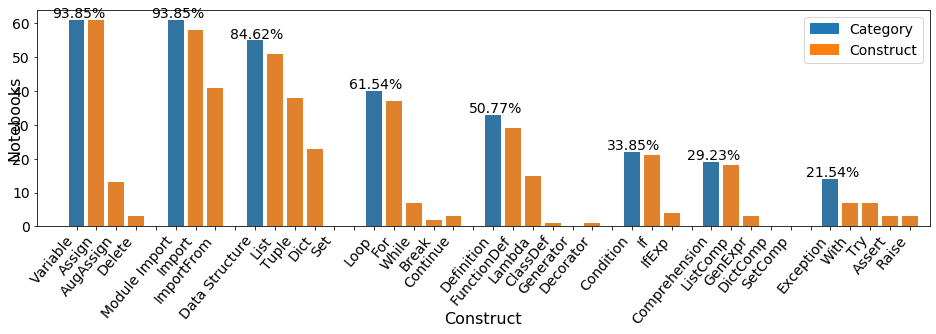

(Popular) 


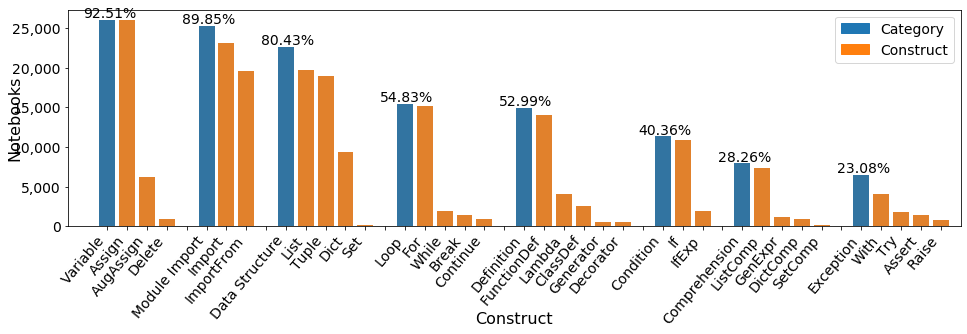

In [24]:
def ast_fig(data, prefix):
    full_histogram, notebooks = data
    total_notebooks = len(notebooks)
    with savefig(prefix + "a3_ast", 16, 7):
        elements = [[x[2]] for x in full_histogram]

        index = sns.color_palette(n_colors=2)
        colors = [
            index[x[1].count(">")] for x in full_histogram
        ]

        ax = sns.barplot(data=elements, palette=colors)
        ax.xaxis.set_ticklabels([x[0] for x in full_histogram], rotation=50, ha="right")
        #ax.set_xticklabels(xticklabels, rotation = 45, ha="right")
        #df2 = pd.DataFrame(elements, columns=["Constructs", "Type", "Quantity"])
        #ax = sns.barplot(x="Constructs", y="Quantity", data=df2,  palette=colors)
        first_color = ax.patches[0].get_facecolor()
        for p in ax.patches:
            if p.get_facecolor() == first_color and p.get_height() != 0:
                text = "{:.2%}".format(p.get_height() / total_notebooks)
                ax.annotate(text, (p.get_x() + 0.5, p.get_height() + total_notebooks/100), ha="center")
        fig = ax.get_figure()
        #plt.xticks(rotation=90)
        legend_patches = [
            matplotlib.patches.Patch(color=index[0], label='Category'),
            matplotlib.patches.Patch(color=index[1], label='Construct'),
           # matplotlib.patches.Patch(color=index[2], label='Subfeature'),
        ]
        ax.set_xlim(-2, 43) # 46 if it has IPython
        ax.set(ylabel='Notebooks', xlabel='Construct')
        ax.xaxis.labelpad = -15
        ax.yaxis.labelpad = -10
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: "{0:,}".format(int(x))))
        #plt.xticks(rotation=60)
        plt.legend(handles=legend_patches)
        plt.gcf().subplots_adjust(bottom=0.45)
group_run(zip(full_histogram, dbmt(modules)), DBMT, ast_fig);

## AST Variables

In [25]:
def create_hist(data, prefix):
    full_histogram, notebooks = data
    total_notebooks = len(notebooks)
    hist = pd.DataFrame(full_histogram, columns=["Element", "Type", "Quantity"])
    hist["Percentage"] = hist["Quantity"] / total_notebooks
    return hist
hist = group_run(zip(full_histogram, dbmt(modules)), DBMT, create_hist, plot=False);

In [26]:
dbmt_relative_var(
    "Notebooks with functions: {}", "a3_functions_ast", 
    hist, dbmt(modules), "{:,}",
    fn=lambda hist: next(hist[hist["Element"] == "FunctionDef"]["Quantity"].iteritems())[1]
)

Notebooks with functions: a3_functions_ast


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"481,285 (54.28%)",None,None,None,None,None
1,(Sample),sd_,29 (44.62%),0.01%,0.00%,82.19%,(-) 17.81%,-9.66%
2,(Popular),td_,"14,045 (49.90%)",2.92%,1.58%,91.93%,(-) 8.07%,-4.38%


In [27]:
dbmt_relative_var(
    "Notebooks with classes: {}", "a3_class_ast", 
    hist, dbmt(modules), "{:,}",
    fn=lambda hist: next(hist[hist["Element"] == "ClassDef"]["Quantity"].iteritems())[1]
)

Notebooks with classes: a3_class_ast


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"75,809 (8.55%)",None,None,None,None,None
1,(Sample),sd_,1 (1.54%),0.00%,0.00%,17.99%,(-) 82.01%,-7.01%
2,(Popular),td_,"2,506 (8.90%)",3.31%,0.28%,104.14%,(+) 4.14%,0.35%


In [28]:
total_intersection = dbmt(asts[
    (
        (asts["ast_functiondef"] != 0)
        | (asts["ast_asyncfunctiondef"] != 0)
        #| (notebooks["ast_classdef"] != 0)
      #  | (notebooks["ast_lambda"] != 0)
    ) & (
        (
            (asts["ast_ifexp"] != 0)
            | (asts["ast_if"] != 0)
        ) | (
            (asts["ast_for"] != 0)
            | (asts["ast_asyncfor"] != 0) 
            | (asts["ast_while"] != 0) 
            | (asts["ast_break"] != 0) 
            | (asts["ast_continue"] != 0)
        )
    )
])
total_control_flow = dbmt(asts[
    (
        (asts["ast_ifexp"] != 0)
        | (asts["ast_if"] != 0)
    ) | (
        (asts["ast_for"] != 0)
        | (asts["ast_asyncfor"] != 0) 
        | (asts["ast_while"] != 0) 
        | (asts["ast_break"] != 0) 
        | (asts["ast_continue"] != 0)
    )

])
dbmt_relative_var(
    "Notebooks with definitions and conditions or loops: {}", 
    "a3_definitions_and_conditions_or_loops",
    total_intersection, total_control_flow,
)

Notebooks with definitions and conditions or loops: a3_definitions_and_conditions_or_loops


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"428,818 (71.02%)",None,None,None,None,None
1,(Sample),sd_,24 (57.14%),0.01%,0.00%,80.46%,(-) 19.54%,-13.88%
2,(Popular),td_,"12,057 (72.16%)",2.81%,2.00%,101.61%,(+) 1.61%,1.14%


This notebook analyzed general characteristics of modules and asts to answer RQ3 and RQ4 for the paper. There are other analyses that did no make into the paper. For those, refer to E4.Modules and E5.AST.